In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn, resnet34

In [3]:
path = Path('/home/jupyter/data/carvana')
path.ls()

[PosixPath('/home/jupyter/data/carvana/train_masks.zip'),
 PosixPath('/home/jupyter/data/carvana/carvana-image-masking-challenge.zip'),
 PosixPath('/home/jupyter/data/carvana/metadata.csv'),
 PosixPath('/home/jupyter/data/carvana/test.zip'),
 PosixPath('/home/jupyter/data/carvana/labels'),
 PosixPath('/home/jupyter/data/carvana/train.zip'),
 PosixPath('/home/jupyter/data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('/home/jupyter/data/carvana/test'),
 PosixPath('/home/jupyter/data/carvana/cut_models'),
 PosixPath('/home/jupyter/data/carvana/train_masks.csv'),
 PosixPath('/home/jupyter/data/carvana/train'),
 PosixPath('/home/jupyter/data/carvana/sample_submission.csv'),
 PosixPath('/home/jupyter/data/carvana/train_hq.zip'),
 PosixPath('/home/jupyter/data/carvana/test_hq.zip')]

In [4]:
path_train = path/'train'
path_mask = path/'labels/original2'
path_img = path/'train/original'

In [5]:
path_mask.ls()[:3], path_img.ls()[:3]

([PosixPath('/home/jupyter/data/carvana/labels/original2/351c583eabd6_03.png'),
  PosixPath('/home/jupyter/data/carvana/labels/original2/6d375bc2ece1_15.png'),
  PosixPath('/home/jupyter/data/carvana/labels/original2/5fb012d30fd9_05.png')],
 [PosixPath('/home/jupyter/data/carvana/train/original/c4ac16c0dd59_15.jpg'),
  PosixPath('/home/jupyter/data/carvana/train/original/85cba1a00135_02.jpg'),
  PosixPath('/home/jupyter/data/carvana/train/original/6bfd601be25e_12.jpg')])

(torch.Size([1, 1280, 1918]), None)

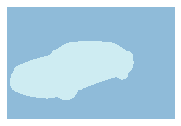

In [6]:
mask_f = path_mask.ls()[0]
mask = open_mask(mask_f)
mask.shape, mask.show()

(torch.Size([3, 1280, 1918]), None)

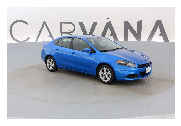

In [7]:
img_f = path_img.ls()[0]
img = open_image(img_f)
img.shape, img.show()

In [8]:
src_size = np.array(img.shape[1:]); src_size

array([1280, 1918])

In [9]:
size = src_size // 4
bs = 10
size

array([320, 479])

In [10]:
get_y_fn = lambda x: path_img/x.with_suffix('.jpg').name

In [11]:
src = ImageImageList.from_folder(path_mask).split_by_rand_pct(0.2, seed=42)

In [12]:
data = (src
        .label_from_func(get_y_fn)
        .transform(get_transforms(), tfm_y=True, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=True, do_x=False))

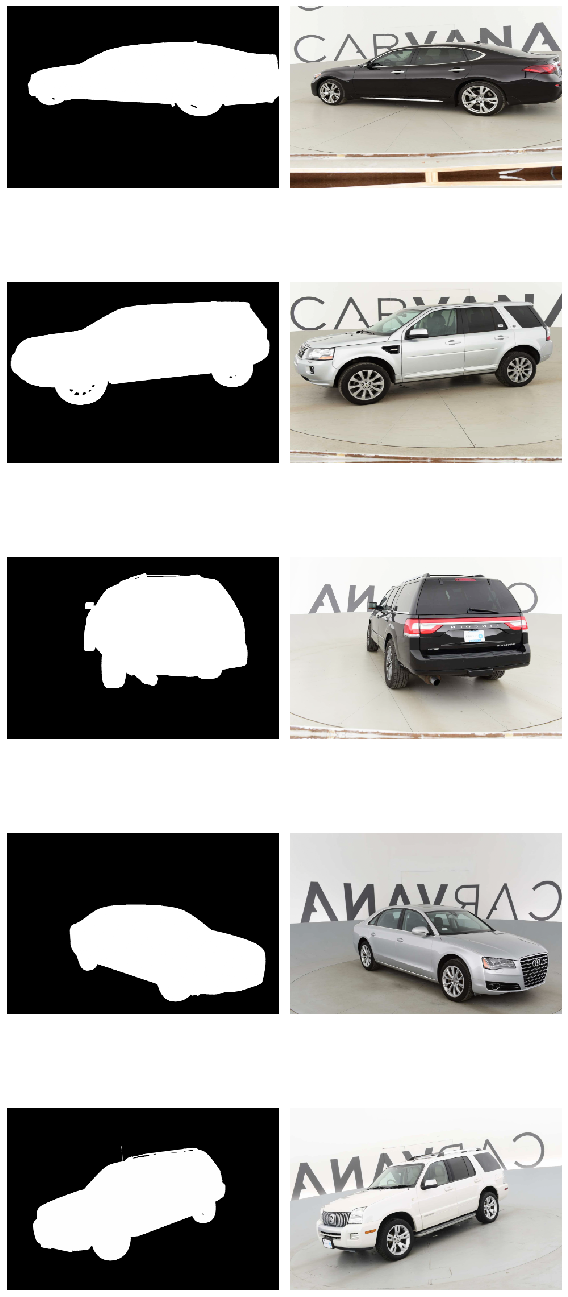

In [13]:
data.show_batch()

In [14]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
base_loss = F.l1_loss

In [16]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layers, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layers))
              ] + [f'gram_{i}' for i in range(len(layers))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
res_m = resnet34(True).cuda().eval()
requires_grad(res_m, False)

In [18]:
layers = [res_m.layer2, res_m.layer3, res_m.layer4]
feat_loss = FeatureLoss(res_m, layers=layers, layer_wgts=[5, 15, 2])

In [19]:
wd = 1e-3
learn = unet_learner(data, models.resnet34, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
learn.path = path_train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


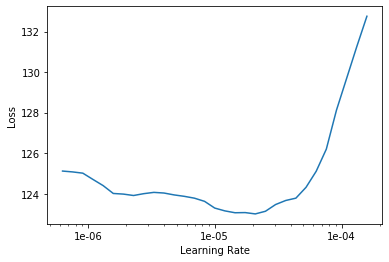

In [20]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-5
learn.fit_one_cycle(3, lr, pct_start=0.8)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,12035.164062,81735.750000,150.929825,32.242863,28.791456,22.781820,53450.242188,21300.962891,6749.814453,05:30
1,10636908544.000000,15620062208.000000,665569.812500,11345.726562,10289.288086,8320.719727,10132188160.000000,4421925376.000000,1065252352.000000,05:24


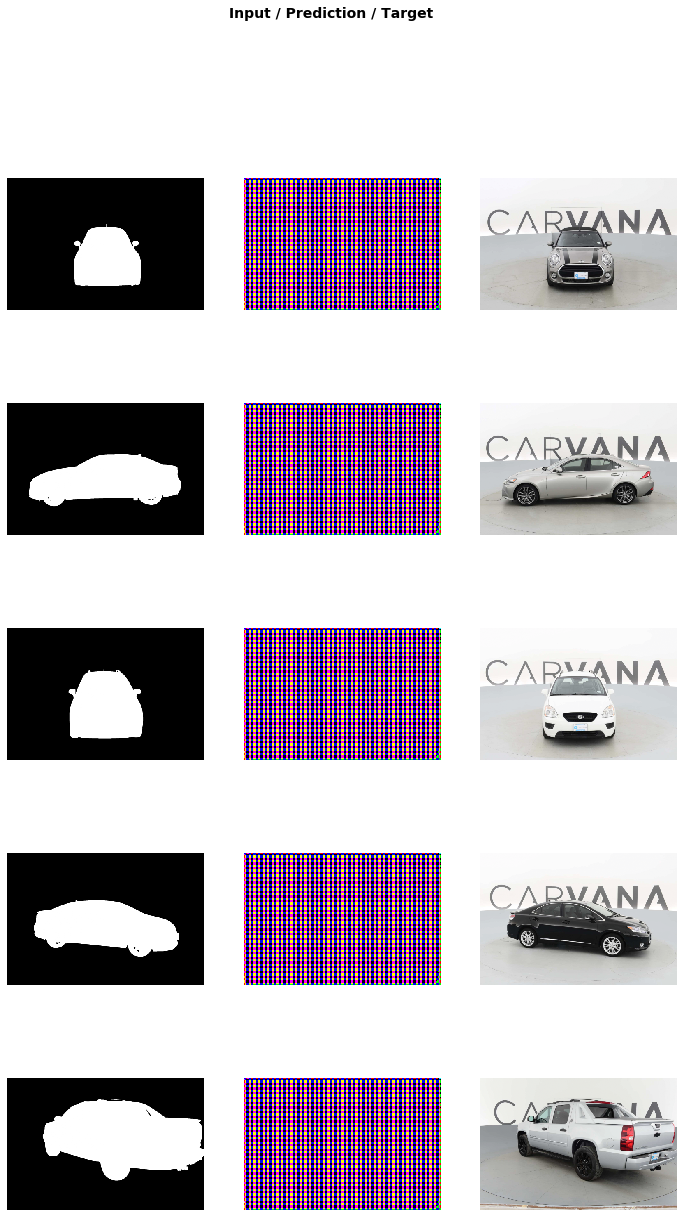

In [18]:
learn.show_results()